# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Recursive feature elimination (RFE)



# What is recursive feature elimination?
<hr style="border:2px solid black"> </hr>


- Fewer features can allow machine learning algorithms to run more efficiently (less space or time complexity) and be more effective. Some machine learning 
algorithms can be misled by irrelevant input features, resulting in worse predictive performance.

- RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired 
number remains. 

- This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the 
least important features, and re-fitting the model. 

- This process is repeated  until a specified number of features remains.



# Import modules
<hr style="border:2px solid black"> </hr>

In [43]:
from matplotlib import pyplot
from numpy import mean, std
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import Perceptron
from sklearn.feature_selection import RFECV
from IPython.display import Markdown, display
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.datasets import make_classification, make_regression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# RFE for classification
<hr style="border:2px solid black"> </hr>

In [11]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.886 (0.028)


In [13]:
# fit the model on all available data
pipeline.fit(X, y)
# make a prediction for one example
data = [[2.56999479, -0.13019997, 3.16075093, -4.35936352, -1.61271951, -1.39352057,
    -2.48924933, -1.93094078, 3.26130366, 2.05692145]]
yhat = pipeline.predict(data) 
print('Predicted Class: %d' % (yhat))

Predicted Class: 1


# RFE for regression
<hr style="border:2px solid black"> </hr>


- We can use the make regression() function to create a synthetic regression problem with 
1,000 examples and 10 input features, five of which are important and five of which 
are redundant.



In [21]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5) 
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -27.246 (3.104)



- The scikit-learn library makes the MAE negative so that it is maximized instead of minimized. This means that negative MAE values closer to zero are better and a perfect model has a MAE of 0. 



In [23]:
# create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5) 
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# fit the model on all available data
pipeline.fit(X, y)
# make a prediction for one example
data = [[-2.02220122, 0.31563495, 0.82797464, -0.30620401, 0.16003707, -1.44411381,
    0.87616892, -0.50446586, 0.23009474, 0.76201118]]
yhat = pipeline.predict(data) 
print('Predicted: %.3f' % (yhat))

Predicted: -84.288


# RFE hyperparameters - explore number of features
<hr style="border:2px solid black"> </hr>


- An important hyperparameter for the RFE algorithm is the number of features to select. 
- In the previous section, we used an arbitrary number of selected features, five, which matches the number of informative features in the synthetic dataset. 
- In practice, we  cannot know the best number of features to select with RFE; instead, it is good practice to test different values



In [24]:
# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5,
    random_state=1)
    return X, y
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2, 10):
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i) 
        model = DecisionTreeClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) 
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
    return scores


In [29]:
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>2 0.715 (0.048)
>3 0.821 (0.034)
>4 0.875 (0.036)
>5 0.885 (0.031)
>6 0.886 (0.028)
>7 0.888 (0.028)
>8 0.890 (0.027)
>9 0.887 (0.028)


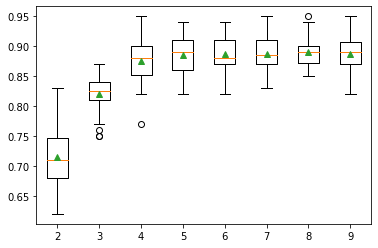

In [30]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


- We can see that performance improves as the number of features increase and perhaps peaks around 4-to-7 as we might expect, given that only five features are relevant 
to the target variable.



# Automatically select the number of features
<hr style="border:2px solid black"> </hr>


- It is also possible to automatically select the number of features chosen by RFE. 

- This can be achieved by performing cross-validation evaluation of different numbers of features as we did in the previous section and automatically selecting the number 
of features that resulted in the best mean score. 

- The RFECV class implements this. The RFECV is configured just like the RFE class regarding the choice of the algorithm 
that is wrapped. Additionally, the minimum number of features to be considered can be specified via the min features to select argument (defaults to 1) and we can also specify
the type of cross-validation and scoring to use via the cv (defaults to 5) and scoring arguments (uses accuracy for classification).



In [32]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5,
    random_state=1)
# create pipeline
rfe = RFECV(estimator=DecisionTreeClassifier()) 
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)]) 
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.884 (0.026)



- In this case, we can see the RFE that uses a decision tree and automatically selects a number of features and then fits a decision tree on the selected features achieves a 
classification accuracy of about 88.6 percent.



# Which features eere selected?
<hr style="border:2px solid black"> </hr>

In [33]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
    print('Column: %d, Selected=%s, Rank: %d' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected=False, Rank: 5
Column: 1, Selected=False, Rank: 4
Column: 2, Selected=True, Rank: 1
Column: 3, Selected=True, Rank: 1
Column: 4, Selected=True, Rank: 1
Column: 5, Selected=False, Rank: 6
Column: 6, Selected=True, Rank: 1
Column: 7, Selected=False, Rank: 2
Column: 8, Selected=True, Rank: 1
Column: 9, Selected=False, Rank: 3


# Explore Base Algorithm
<hr style="border:2px solid black"> </hr>


- There are many algorithms that can be used in the core RFE, as long as they provide some 
indication of variable importance. Most decision tree algorithms are likely to report the
same general trends in feature importance, but this is not guaranteed. 
- It might be helpful to explore the use of different algorithms wrapped by RFE. 



In [36]:
# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5,
    random_state=1)
    return X, y

# get a list of models to evaluate
def get_models():
    models = dict()
    # lr
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # perceptron
    rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5) 
    model = DecisionTreeClassifier()
    models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5) 
    model = DecisionTreeClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) 
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
    return scores

In [44]:
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.891 (0.032)
>per 0.841 (0.036)
>cart 0.884 (0.035)
>rf 0.858 (0.039)
>gbm 0.888 (0.031)



- In this case, the results suggest that linear algorithms like logistic regression
and the Perceptron might select better features more reliably than the chosen 
decision tree and ensemble of decision tree algorithms.



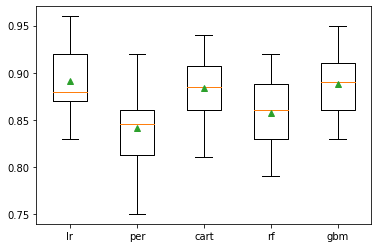

In [45]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


- A box and whisker plot is created for the distribution of accuracy scores for each 
configured wrapped algorithm. We can see the general trend of good performance with 
logistic regression, CART and perhaps GBM. 
- This highlights that even thought the actual
model used to fit the chosen features is the same in each case, the model used within 
RFE can make an important difference to which features are selected and in turn the 
performance on the prediction problem.
  


# References
<hr style="border:2px solid black"> </hr>


- https://machinelearningmastery.com/rfe-feature-selection-in-python/

